tracking_data_setup.py -> this notebook -> model_train.ipynb

In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.special import gammaln
from scipy.optimize import minimize

## Load Data

# Feature Creation

Tracking features created in trackin_data_setup.py but code replicated here to easily debug

## Non-Tracking Features

Close Endzone: within 5 yards of a touchdown (hypothesis: less pressure because shorter and quicker passes) <br>
Close Safety: within 5 yards of own endzone (hypothesis: more careful with passing in fear of getting sacked for a safety, so less pressure)

In [410]:
model_data = pd.read_csv('model_data.csv')
player_play = pd.read_csv('data/player_play.csv')
players = pd.read_csv('data/players.csv')

In [411]:
model_data.loc[model_data['absoluteYardlineNumber'] < 15, 'close_endzone'] = 1.0
model_data['close_endzone'] = model_data['close_endzone'].fillna(0.0)

model_data.loc[model_data['absoluteYardlineNumber'] > 100, 'close_safety'] = 1.0
model_data['close_safety'] = model_data['close_safety'].fillna(0.0)

Two minute drill: In last 2 minutes of quarters 2 and 4 (hypothesis: more aggresive with passes leading to more pressure)

In [412]:
def time_to_minutes(time_str):
    minutes, seconds = map(int, time_str.split(":"))
    return minutes + (seconds / 60)

model_data['gameClock'] = model_data['gameClock'].apply(lambda x: time_to_minutes(x))
model_data.loc[(model_data['quarter'].isin([2, 4])) & (model_data['gameClock'] < 2), 'two_minute_drill'] = 1.0
model_data['two_minute_drill'] = model_data['two_minute_drill'].fillna(0.0)

Critical down: 3rd or 4th down (much more pressure on 3rd and 4th down compared to 1st or 2nd)

In [413]:
model_data.loc[model_data['down'].isin([3, 4]), 'critical_down'] = 1.0
model_data['critical_down'] = model_data['critical_down'].fillna(0.0)

Average yards to go: remaining yards for a first divided by remaining plays (1st down = 3 plays, 2nd down = 2 plays, 3rd down = 1 play, 4th down = 1 play) <br>
long_distance: 1 if over 5 average yards to go, 0 if not (more pressure if further yards to go)

In [414]:
model_data['avg_yards_to_go'] = model_data['yardsToGo']/(4-model_data['down'].clip(upper=3))
model_data.loc[model_data['avg_yards_to_go'] > 5, 'long_distance'] = 1.0
model_data['long_distance'] = model_data['long_distance'].fillna(0.0)

Score differential: offense score - defense score <br>
Big score diff: 1 if down 14 or more points, 0 if not (more pressure if teams are getting more aggresive because they are down by two scores)

In [415]:
#model_data = pd.merge(model_data, games.loc[:, ['gameId', 'homeTeamAbbr', 'visitorTeamAbbr', 'week']], on = 'gameId', how ='left')
model_data.loc[model_data['possessionTeam'] == model_data['homeTeamAbbr'], 'score_diff'] = model_data['preSnapHomeScore'] - model_data['preSnapVisitorScore'] 
model_data.loc[model_data['possessionTeam'] == model_data['visitorTeamAbbr'], 'score_diff'] = model_data['preSnapVisitorScore'] - model_data['preSnapHomeScore'] 
model_data['binned_score_diff'] = pd.qcut(model_data['score_diff'], q=8)
model_data.loc[model_data['score_diff'] <= -14, 'big_score_diff'] = 1.0
model_data['big_score_diff'] = model_data['big_score_diff'].fillna(0.0)

low play clock: play clock is under 4 seconds, meaning the defensive line has a better chance to time the snap and generate more pressure

In [416]:
model_data.loc[model_data['playClockAtSnap'] < 4, 'low_play_clock'] = 1.0
model_data['low_play_clock'] = model_data['low_play_clock'].fillna(0.0)

In [417]:
model_data['expected_point_bucket'] = pd.qcut(model_data['expectedPoints'], q=  3, labels=[0, 1, 2])

## Player Specific Features

In [418]:
qbs = pd.merge(player_play, players.loc[:, ['nflId', 'position', 'displayName']], on = 'nflId', how='left')
qbs = qbs.loc[qbs['position'] == 'QB']
model_data = pd.merge(model_data, qbs.loc[:, ['gameId', 'playId', 'nflId', 'displayName']], on = ['gameId', 'playId'], how = 'left')
model_data = model_data.rename({'nflId':'qbId', 'displayName':'qbName'}, axis=1)
pressure_rate = model_data.groupby('qbId')['causedPressure'].agg(['sum', 'count'])
overall_mean = model_data['causedPressure'].mean()

In [419]:
def beta_binomial_pmf(k, n, alpha, beta):
    """
    Probability mass function for the beta-binomial distribution
    
    Parameters:
    k: number of successes
    n: number of trials
    alpha, beta: parameters of the beta distribution
    """
    pmf = np.exp(
        gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1) +
        gammaln(k + alpha) + gammaln(n - k + beta) - gammaln(n + alpha + beta) +
        gammaln(alpha + beta) - gammaln(alpha) - gammaln(beta)
    )
    return pmf

def neg_log_likelihood(params, data):
    """
    Negative log likelihood function for the beta-binomial distribution
    
    Parameters:
    params: [alpha, beta]
    data: list of tuples (successes, trials)
    """
    alpha, beta = params
    if alpha <= 0 or beta <= 0:  # Parameters must be positive
        return np.inf
    
    log_likelihood = 0
    for successes, trials in data:
        p = beta_binomial_pmf(successes, trials, alpha, beta)
        if p > 0:
            log_likelihood += np.log(p)
        else:
            return np.inf
    
    return -log_likelihood

def fit_beta_binomial(data, overall_mean):
    """
    Fit beta-binomial distribution using MLE with constraint alpha/(alpha+beta) = overall_mean
    
    Parameters:
    data: list of tuples (successes, trials)
    overall_mean: target mean rate
    
    Returns:
    alpha, beta: optimized parameters
    """
    def objective(x):
        # x is alpha, beta is determined by constraint
        alpha = x[0]
        beta = alpha * (1 - overall_mean) / overall_mean
        return neg_log_likelihood([alpha, beta], data)
    
    # Initial guess for alpha (try a few values)
    best_result = None
    best_value = np.inf
    
    for init_alpha in [1, 5, 10, 20]:
        result = minimize(
            objective,
            x0=[init_alpha],
            method='L-BFGS-B',
            bounds=[(0.0001, None)],
        )
        
        if result.fun < best_value:
            best_value = result.fun
            best_result = result
    
    final_alpha = best_result.x[0]
    final_beta = final_alpha * (1 - overall_mean) / overall_mean
    
    return final_alpha, final_beta

# Example data: list of (successes, trials) for each player
data_tups = list(pressure_rate.itertuples(index=False, name=None))     # Player 3: 3 successes in 5 trials

# Calculate overall mean from data
overall_mean = model_data['causedPressure'].mean()

# Fit the model
alpha, beta = fit_beta_binomial(data_tups, overall_mean)
print(f"Fitted parameters: alpha = {alpha:.2f}, beta = {beta:.2f}")

Fitted parameters: alpha = 20.02, beta = 39.59


In [420]:
model_data[['qb_current_pressure_count', 'qb_current_tot_snaps']] = model_data.groupby('qbId')['causedPressure'].agg(['cumsum', 'cumcount'])

In [421]:
model_data['qb_current_pressure_count'] += alpha
model_data['qb_current_tot_snaps'] += (alpha + beta)

In [422]:
model_data['current_pressure_rate'] = model_data['qb_current_pressure_count'] / model_data['qb_current_tot_snaps']

In [423]:
model_data.to_csv('model_data.csv')

## Tracking Features

* currently only set up for week 1 as prototype

In [387]:
tracking_raw = pd.read_csv('data/tracking_week_1.csv')

In [388]:
tracking = pd.merge(tracking_raw, plays.loc[:, ['gameId', 'playId', 'absoluteYardlineNumber']], on = ['gameId', 'playId'], how='left') #add absoluteYardLine

In [389]:
def set_up_tracking(tracking_data):
    """
    Filters tracking data to last frame before the snap, adds player positions, and creates distance from line of scrimmage column
    """
    #Set up tracking data
    tracking_pre_snap = tracking_data[tracking_data['frameType'] == "BEFORE_SNAP"]
    tracking_pre_snap = pd.merge(tracking_pre_snap, plays[['gameId', 'playId', 'isDropback']], on = ['gameId', 'playId'], how = 'inner')
    tracking_pre_snap = tracking_pre_snap[tracking_pre_snap['isDropback']]

    tracking_pre_snap = tracking_pre_snap.groupby(['gameId', 'playId', 'nflId']).last().reset_index()
    #add player positions to filter out defensive backs
    positions = players[['nflId', 'position']]
    tracking_pre_snap = pd.merge(tracking_pre_snap, positions, on = 'nflId', how='inner')
    #find vertical distance between player and football
    tracking_pre_snap['distance_from_line'] = np.abs(tracking_pre_snap['x'] - tracking_pre_snap['absoluteYardlineNumber'])

    #create binary column for offense or defense    
    position_dict = {
    'G':1, 'DT':0, 'C':1, 'DE':0, 'T':1, 'NT':0, 'OLB':0, 'MLB':0, 'ILB':0, 'LB':0, 'WR':1, 'CB':0, 'QB':1, 'SS':0, 'RB':1, 'TE':1, 'FS':0, 'FB':1, 'DB':0
    }
    tracking_pre_snap['isOffense'] = tracking_pre_snap['position'].map(position_dict)
    return tracking_pre_snap

In [390]:
def create_linspread_feature(model_data, tracking_pre_snap):
    """
    Takes tracking data and calculates the spread among defensive lineman (max y - min y of defensive lineman) before the snap and returns this as a feature in the overall model_data
    """
    tracking_pre_snap = tracking_pre_snap[tracking_pre_snap['position'].isin(['DE', 'NT', 'SS', 'FS', 'OLB', 'DT', 'CB', 'ILB', 'MLB', 'DB', 'LB'])]
    #filter out DBs and have other players need to be within 1.5 yards of the ball to be determined on the line
    line_spread = tracking_pre_snap.loc[(tracking_pre_snap['distance_from_line'] <= 2) & ~(tracking_pre_snap['position'].isin(['SS', 'FS', 'DB', 'CB']))]
    #find minimum horziontal and maximum horizontal position of filtered lineman
    spread = line_spread.groupby(['gameId', 'playId'])['y'].agg(['max', 'min']).reset_index()
    #calculate dline spread
    spread['dlinespread'] = spread['max'] - spread['min']
    model_data = pd.merge(model_data, spread.loc[:,['gameId', 'playId', 'dlinespread']], on = ['gameId', 'playId'], how='left')
    return model_data

In [391]:
def create_max_distance_to_offense(model_data, tracking_df):
    """
    Calculates minimum distance to an offensive lineman for each defensive lineman, and takes the max of these distances for each play and returns it as a feature in model_data
    """
    lineman = tracking_df.loc[(tracking_df['distance_from_line'] <= 2) & (tracking_df['position'].isin(['DE', 'NT', 'OLB', 'DT', 'ILB', 'MLB', 'LB', 'G', 'C', 'T']))].copy()
    lineman.loc[:, 'max_distance_to_offense'] = np.nan
    for (game, play), play_df in lineman.groupby(['gameId', 'playId']):
        offense = play_df[play_df['isOffense'] == 1]
        defense = play_df[play_df['isOffense'] == 0]

        offense_coords = offense[['x', 'y']].values
        defense_coords = defense[['x', 'y']].values

        distances = np.sqrt(
                ((defense_coords[:, np.newaxis, 0] - offense_coords[:, 0]) ** 2) +
                ((defense_coords[:, np.newaxis, 1] - offense_coords[:, 1]) ** 2)
            )
        
        min_distances = distances.min(axis=1)

        lineman.loc[defense.index, 'max_distance_to_offense'] = min_distances

    max_lineman_dist = lineman.groupby(['gameId', 'playId'])['max_distance_to_offense'].max().reset_index()
    model_data = pd.merge(model_data, max_lineman_dist, on =['gameId', 'playId'], how = 'left')
    return model_data

In [392]:
def find_gap_coords(tracking_df):
    olineman = tracking_df.loc[(tracking_df['position'].isin(['DE', 'NT', 'OLB', 'DT', 'ILB', 'MLB', 'LB', 'G', 'C', 'T']) & (tracking_df['isOffense'] == 1))].copy()
    results = []
    for (gameId, playId), group in olineman.groupby(['gameId', 'playId']):
        coords = group.sort_values('y')[['x', 'y']]
        gaps = [(coords.iloc[0, 0], coords.iloc[0, 1] - 1.5)]
        for i in range(len(coords)-1):
            gap_x = (coords.iloc[i, 0] + coords.iloc[i+1, 0]) / 2
            gap_y = (coords.iloc[i, 1] + coords.iloc[i+1, 1]) / 2
            gaps.append((gap_x, gap_y))
        gaps.append((coords.iloc[4, 0], coords.iloc[4, 1] + 1.5))
        results.append({'gameId':gameId, 'playId':playId, 'gaps':gaps})
    gaps_df = pd.DataFrame(results)
    return gaps_df

def find_dline_coords(tracking_df):
    dlineman = tracking_df.loc[(tracking_df['distance_from_line'] <= 2) & (tracking_df['position'].isin(['DE', 'NT', 'OLB', 'DT', 'ILB', 'MLB', 'LB']))].copy()
    results = []
    for (gameId, playId), group in dlineman.groupby(['gameId', 'playId']):
        coords = group.sort_values('y')
        coords = list(zip(coords['x'], coords['y']))
        results.append({'gameId':gameId, 'playId':playId, 'dline_coords':coords})
    dline_coords_df = pd.DataFrame(results)
    return dline_coords_df


In [393]:
tracking_df = set_up_tracking(tracking)

In [394]:
model_data = create_linspread_feature(model_data, tracking_df)
model_data = create_max_distance_to_offense(model_data, tracking_df)

In [395]:
def build_gap_influence(model_data, tracking_df, sigma):
    dline_coords_df = find_dline_coords(tracking_df)
    gaps_df = find_gap_coords(tracking_df)
    dline_influence_df = pd.merge(dline_coords_df, gaps_df, on = ['gameId', 'playId'], how = 'left')

    gap_influence = pd.DataFrame(columns=['gameId', 'playId', 'gap1_influence', 'gap2_influence', 'gap3_influence', 'gap4_influence', 'gap5_influence', 'gap6_influence'])
    for (gameId, playId), group in dline_influence_df.groupby(['gameId', 'playId']):
        d_line = np.array(group['dline_coords'].tolist()).squeeze()
        gaps = np.array(group['gaps'].tolist()).squeeze()
        n_players = len(d_line)
        n_gaps = len(gaps)
        influences = np.zeros((n_gaps, n_players))

        for i, player_pos in enumerate(d_line):
            for j, gap_pos in enumerate(gaps):
                distance = np.sum((player_pos - gap_pos)**2)
                influences[j, i] =  np.exp(-distance / (2*sigma**2))
        
        player_columns = [f'Player_{i+1}' for i in range(n_players)]
        df_influence = pd.DataFrame(influences, columns=player_columns)
        
        # Add gap coordinates and total influence
        df_influence['Gap_X'] = gaps[:, 0]
        df_influence['Gap_Y'] = gaps[:, 1]
        df_influence['Total_Influence'] = df_influence[player_columns].sum(axis=1)
        if n_gaps == 6:
            gap_influence.loc[len(gap_influence)] = [gameId, playId] + df_influence[player_columns].sum(axis=1).tolist()
        else:
            gap_influence.loc[len(gap_influence)] = [gameId, playId] + df_influence[player_columns].sum(axis=1).tolist()[:6]
    model_data = pd.merge(model_data, gap_influence, on = ['gameId', 'playId'], how='left')
    return model_data

In [396]:
model_data = build_gap_influence(model_data, tracking_df, 2.0)

In [397]:
line_proximity = tracking_df.groupby(['gameId', 'playId'])['distance_from_line'].agg({'max', 'mean'}).reset_index()
line_proximity = line_proximity.rename({'mean':'avg_def_dist_from_line', 'max':'max_def_dist_from_line'}, axis=1)

In [398]:
model_data = pd.merge(model_data, line_proximity, on = ['gameId', 'playId'], how='left')

In [399]:
model_data.to_csv('model_data.csv', index=False)

In [400]:
def plot_influence_heatmap(field_x, field_y, influence_values, d_line_coords, gap_coords):
    """
    Create a heatmap visualization of defensive influence across the field
    
    Parameters:
    field_x, field_y: Meshgrid coordinates for the field
    influence_values: Calculated influence at each point
    d_line_coords: Defensive line positions to plot
    gap_coords: Gap positions to plot
    """
    plt.figure(figsize=(15, 8))
    
    # Plot influence heatmap
    plt.contourf(field_x, field_y, influence_values, levels=20, cmap='YlOrRd')
    plt.colorbar(label='Influence')
    
    # Plot defensive players
    d_line = np.array(d_line_coords)
    plt.scatter(d_line[:, 0], d_line[:, 1], color='blue', s=100, label='Defensive Line')
    
    # Plot gaps
    gaps = np.array(gap_coords)
    plt.scatter(gaps[:, 0], gaps[:, 1], color='green', marker='s', s=100, label='Gaps')
    
    plt.title('Defensive Line Influence Map')
    plt.xlabel('Field Position (yards)')
    plt.ylabel('Field Width (yards)')
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()


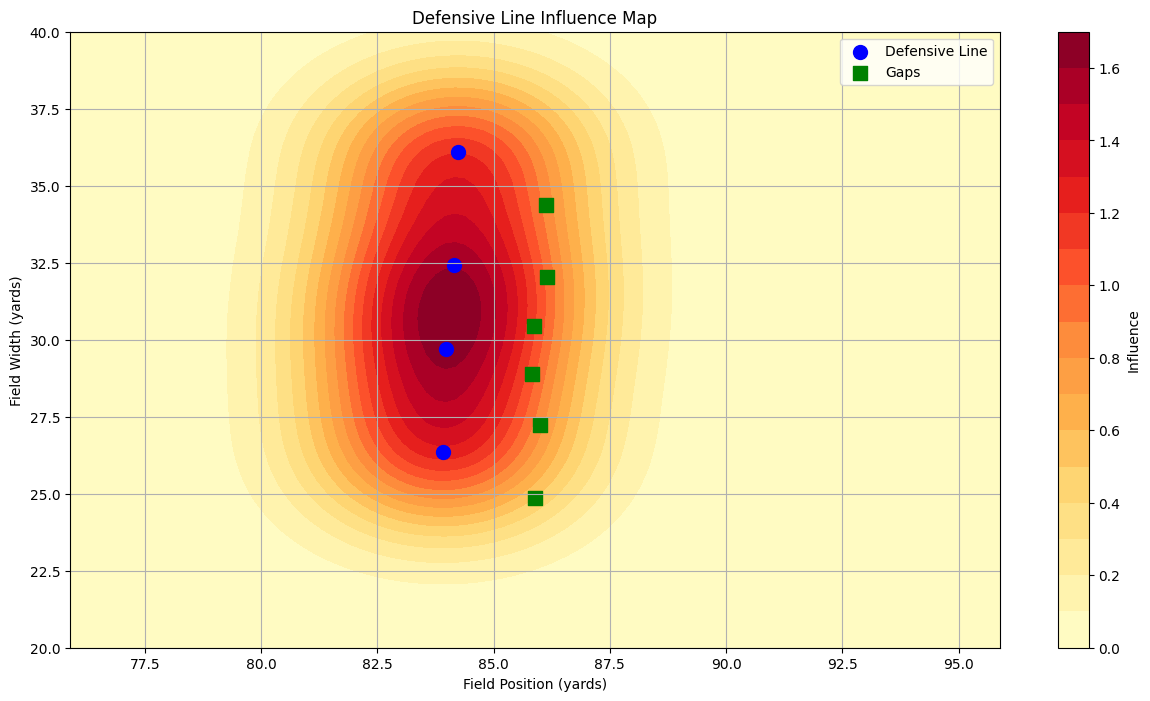

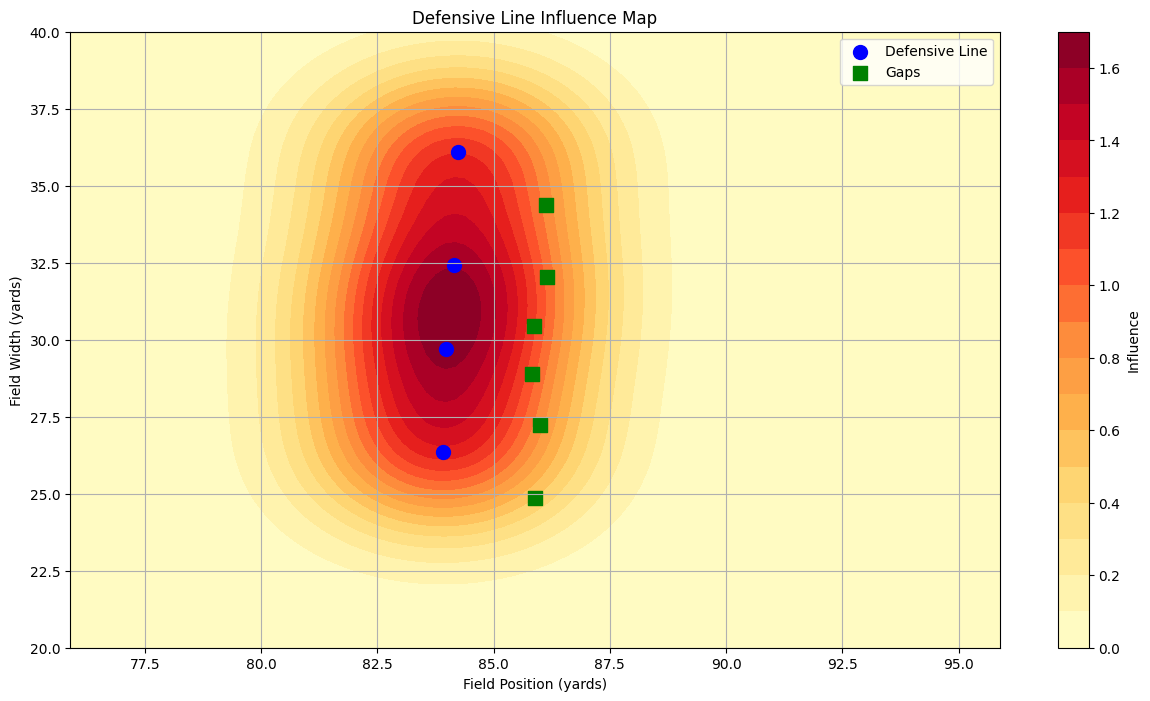

In [401]:
d_line_coords = dline_influence_df.iloc[0]['dline_coords']  # Example defensive line
gap_coords = dline_influence_df.iloc[0]['gaps']

x = np.linspace(gap_coords[0][0]-10, gap_coords[0][0]+10, 100)
y = np.linspace(20, 40, 100)
field_x, field_y = np.meshgrid(x, y)
influence_values = np.zeros_like(field_x)
for i in range(len(field_x)):
    for j in range(len(field_y)):
        point = np.array([field_x[i,j], field_y[i,j]])
        influence_values[i,j] = sum(np.exp(-np.sum((point - d_pos)**2) / (2 * sigma**2)) 
                                    for d_pos in d_line_coords)
    
    # Plot results
plot_influence_heatmap(field_x, field_y, influence_values, d_line_coords, gap_coords)